# SpaCy - Named Entity Recognition (NER)

## Importing Libraries and Data

In [1]:
# Importing necessary libraries
import re
import nltk
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import gensim
import pyLDAvis.gensim
from collections import Counter

In [2]:
# Import local functions from a custom module
from general_functions import *

# AWS Credentials and S3 Bucket Connection
# Load AWS credentials from a JSON file
with open("aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)

# Specify the S3 bucket name
bucket = "fs-reghub-news-analysis"

# Establish a connection to AWS and download the data files
aws = awsOps(aws_creds_json)
df = aws.get_df(bucket=bucket, file="data_rule_labels_v1.csv")
df_categories = aws.get_df(bucket=bucket, file="rule_labels_v1.csv")

## Data Overview

In [3]:
# Display basic information and statistics about the dataset
df

,Unnamed: 0,_id,_index,_score,_type,concepts,found_dates,id,internal_links,keywords,...,news_title,news_topic,news_type,references,sentiment_label,sentiment_score,source_country,source_name,source_type,rule_labels_comb
0,0,fin1023Preslofreshbuy917302,2021_reghub_new,NaN,_doc,NaN,[],fin1023Preslofreshbuy917302,[],NaN,...,HelloFresh Buy von Joh. Berenberg Gossler & Co...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.at,Information Provider,['market']
1,1,finichtenStoceaaufbuy322htm,2021_reghub_new,NaN,_doc,NaN,[],finichtenStoceaaufbuy322htm,[],NaN,...,BERENBERG stuft Nordea auf 'Buy' Finanznachri...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,finanznachrichten.de,Information Provider,['market']
2,2,fin1023Pressanofibuy917301,2021_reghub_new,NaN,_doc,NaN,[],fin1023Pressanofibuy917301,[],NaN,...,Sanofi Buy von Joh. Berenberg Gossler & Co. KG...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.ch,Information Provider,['market']
3,3,fin02023Presnbergbank917304,2021_reghub_new,NaN,_doc,NaN,[],fin02023Presnbergbank917304,[],NaN,...,Sartorius vz Buy (Joh. Berenberg Gossler & Co....,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.net,Information Provider,[]
4,4,walOnlineStocgstuftsanofibuy,2021_reghub_new,NaN,_doc,NaN,[],walOnlineStocgstuftsanofibuy,[],NaN,...,BERENBERG stuft SANOFI auf 'Buy' 30.10.2023 ...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,wallstreet-online.de,Information Provider,"['papers', 'market']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496,14603,EurchosPres9fa0e44b60enhtml,2021_reghub_new,NaN,_doc,NaN,[],EurchosPres9fa0e44b60enhtml,[],NaN,...,Andrea Enria: Interview with Les Échos,"[{""description"":""Compliance"",""relevance"":7,""co...",Press releases,[],NaN,0.0,European Union (EU),European Central Bank (ECB),Central bank,"['legal', 'statements', 'guidelines']"
14497,14604,UBSWillPresllhtmlcaasIDRSS,2021_reghub_new,NaN,_doc,NaN,[],UBSWillPresllhtmlcaasIDRSS,[],NaN,...,Das FintechPortfolio von UBS investiert in die...,"[{""description"":""Digital Transformation"",""rele...",Press releases,[],NaN,0.0,Global,UBS Media Releases,Financial Service Provider,"['reports', 'personnel']"
14498,14605,invrankenPresnd26mrdfranken,2021_reghub_new,NaN,_doc,NaN,[],invrankenPresnd26mrdfranken,[],NaN,...,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[{""description"":""Controlling"",""relevance"":33,""...",Press releases,[],NaN,0.0,Switzerland,investrends,Information provider,"['legal', 'reports', 'market']"
14499,14606,CoirawalsPrestomerswithdrawals,2021_reghub_new,NaN,_doc,NaN,[],CoirawalsPrestomerswithdrawals,[],NaN,...,Hong Kongbased Coinsuper allegedly blocks cust...,"[{""description"":""Daytrading"",""relevance"":49,""c...",Social Media,[],NaN,0.0,Global,Cointelegraph,Information provider,"['legal', 'reports', 'guidelines', 'press']"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14501 entries, 0 to 14500
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14501 non-null  int64  
 1   _id                14501 non-null  object 
 2   _index             14501 non-null  object 
 3   _score             11 non-null     object 
 4   _type              14491 non-null  object 
 5   concepts           2254 non-null   object 
 6   found_dates        13779 non-null  object 
 7   id                 14501 non-null  object 
 8   internal_links     13731 non-null  object 
 9   keywords           2360 non-null   object 
 10  language           14492 non-null  object 
 11  news_author        1979 non-null   object 
 12  news_content       14501 non-null  object 
 13  news_date          14490 non-null  object 
 14  news_label         238 non-null    object 
 15  news_last_updated  11 non-null     object 
 16  news_legalinforce  144

## Data Preprocessing

In [5]:
# Remove specific keywords from the 'concepts' column
keyword_to_remove = "market microstructure"
df = df[~df['concepts'].str.contains(keyword_to_remove, case=False, na=False)]

### Display Number of Mislabeled Articles

In [6]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [7]:
def count_mislabeled_articles(df, text_column='news_content', lang_column='language'):
    mislabeled_en = 0
    mislabeled_de = 0

    for row in df.itertuples():
        try:
            detected_lang = detect(getattr(row, text_column))
            if getattr(row, lang_column) == 'de' and detected_lang == 'en':
                mislabeled_en += 1
            elif getattr(row, lang_column) == 'en' and detected_lang == 'de':
                mislabeled_de += 1
        except Exception as e:
            print(f"Error in detection: {e}")

    print(f"Number of English articles mislabeled as German: {mislabeled_en}")
    print(f"Number of German articles mislabeled as English: {mislabeled_de}")

### Correct Mislabeled Articles

In [8]:
def correct_mislabeled_articles(df, text_column='news_content', lang_column='language'):
    for index, row in df.iterrows():
        try:
            detected_lang = detect(row[text_column])
            if row[lang_column] == 'de' and detected_lang == 'en':
                df.at[index, lang_column] = 'en'
            elif row[lang_column] == 'en' and detected_lang == 'de':
                df.at[index, lang_column] = 'de'
        except Exception as e:
            print(f"Error in detection: {e}")
    return df

In [9]:
# Display the number of mislabeled articles
count_mislabeled_articles(df)

Number of English articles mislabeled as German: 1585
Number of German articles mislabeled as English: 549


In [10]:
# Correct the language labels in the DataFrame
df = correct_mislabeled_articles(df)

In [11]:
# Display the number of mislabeled articles
count_mislabeled_articles(df)

Number of English articles mislabeled as German: 0
Number of German articles mislabeled as English: 0


## NER Demo

In [12]:
%%capture
!python -m spacy download en_core_web_lg

In [13]:
import spacy
from spacy import displacy

# Load the English language model
nlp_en = spacy.load("en_core_web_lg")

C:\Users\xiang\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [14]:
text_1 = """German lender Commerzbank, headquartered in Frankfurt, saw its net profit after tax triple in Q3 2023, reaching €684 million, compared to last year’s €195 million, as reported on October 15, 2023. This prominent financial institution, which has been operational since 1870, attributed the rise to its strategic roadmap focusing on digital innovation and sustainable finance. In the third quarter of 2023, Commerzbank's revenue soared to €2.8 billion, a significant increase from €1.9 billion in 2022. The bank's success is partly attributed to robust customer business and the benefits from the European Central Bank's interest rate policies. Commerzbank's CEO, Manfred Knof, stated in a press conference in Berlin, 'With our refined strategy, we are solidifying our role in the competitive German banking market.' Under 'Strategy 2024', the bank has implemented restructuring measures, including closing 340 branches across Germany and reducing its workforce by 10,000 employees by the end of 2024. Looking ahead, Commerzbank has set a target of €3.4 billion in profits by 2027. This ambitious goal aligns with its new business model focusing on digital banking solutions and expanding into the Asian market. The bank also plans to invest in sustainable finance initiatives, aiming for a 25% reduction in carbon emissions from its investment portfolio by 2025."""

In [15]:
doc_1=nlp_en(text_1)
[(x.text,x.label_) for x in doc_1.ents]

[('German', 'NORP'),
 ('Commerzbank', 'ORG'),
 ('Frankfurt', 'GPE'),
 ('Q3 2023', 'DATE'),
 ('€684 million', 'MONEY'),
 ('last year’s', 'DATE'),
 ('€195 million', 'MONEY'),
 ('October 15, 2023', 'DATE'),
 ('1870', 'DATE'),
 ('the third quarter of 2023', 'DATE'),
 ('Commerzbank', 'ORG'),
 ('€2.8 billion', 'MONEY'),
 ('€1.9 billion', 'MONEY'),
 ('2022', 'DATE'),
 ("the European Central Bank's", 'ORG'),
 ('Commerzbank', 'ORG'),
 ('Manfred Knof', 'PERSON'),
 ('Berlin', 'GPE'),
 ('German', 'NORP'),
 ('340', 'CARDINAL'),
 ('Germany', 'GPE'),
 ('10,000', 'CARDINAL'),
 ('the end of 2024', 'DATE'),
 ('Commerzbank', 'ORG'),
 ('€3.4 billion', 'MONEY'),
 ('2027', 'CARDINAL'),
 ('Asian', 'NORP'),
 ('25%', 'PERCENT'),
 ('2025', 'DATE')]

In [16]:
displacy.render(doc_1, style='ent')

C:\Users\xiang\AppData\Roaming\Python\Python311\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


## NER Analysis - English News Title

### Analysis Setup

In [17]:
# Load the English language model
nlp_en = spacy.load("en_core_web_lg")

# Access the pipeline components to get the labels
ner_labels = nlp_en.get_pipe("ner").labels

# Print the labels and their descriptions
for label in ner_labels:
    print(f"Type: {label}, Description: {spacy.explain(label)}")

Type: CARDINAL, Description: Numerals that do not fall under another type
Type: DATE, Description: Absolute or relative dates or periods
Type: EVENT, Description: Named hurricanes, battles, wars, sports events, etc.
Type: FAC, Description: Buildings, airports, highways, bridges, etc.
Type: GPE, Description: Countries, cities, states
Type: LANGUAGE, Description: Any named language
Type: LAW, Description: Named documents made into laws.
Type: LOC, Description: Non-GPE locations, mountain ranges, bodies of water
Type: MONEY, Description: Monetary values, including unit
Type: NORP, Description: Nationalities or religious or political groups
Type: ORDINAL, Description: "first", "second", etc.
Type: ORG, Description: Companies, agencies, institutions, etc.
Type: PERCENT, Description: Percentage, including "%"
Type: PERSON, Description: People, including fictional
Type: PRODUCT, Description: Objects, vehicles, foods, etc. (not services)
Type: QUANTITY, Description: Measurements, as of weight 

In [18]:
# Filter DataFrame for English and German content
df_en = df[df['language'] == 'en']
df_de = df[df['language'] == 'de']

### Entity Categories

<Axes: >

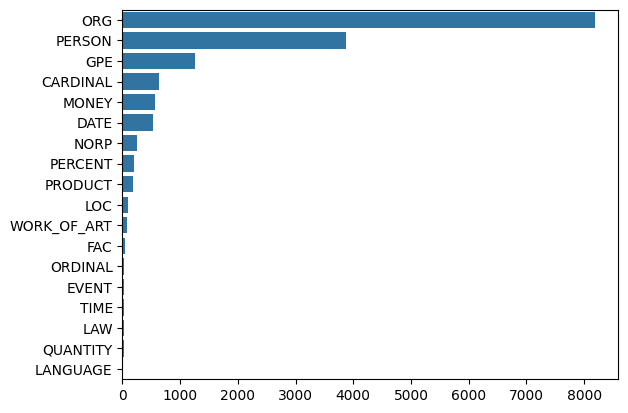

In [19]:
# Define the NER function
def ner_en_tit(text, ent=None):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function 
ent_en = df_en['news_title'].apply(lambda x: ner_en_tit(x))
ent_en = [i for x in ent_en for i in x]

# Count the occurrences of each entity
counter = Counter(ent_en)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### ORG / Organization (Companies, agencies, institutions, etc.)

<Axes: >

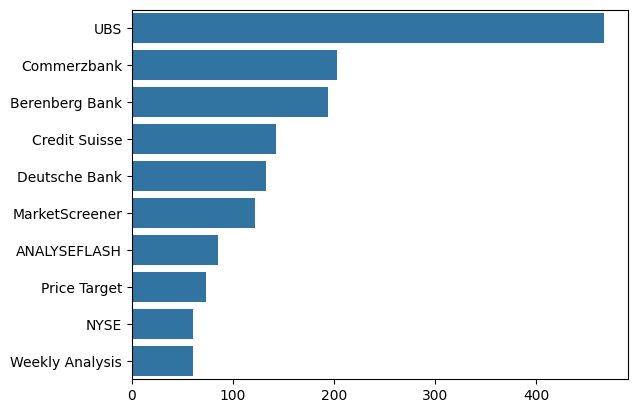

In [20]:
def ner_en_tit(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function 
org_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, ent="ORG"))
org_en = [i for x in org_en for i in x]

# Count the occurrences of each entity
counter = Counter(org_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### PERSON (People, including fictional)

<Axes: >

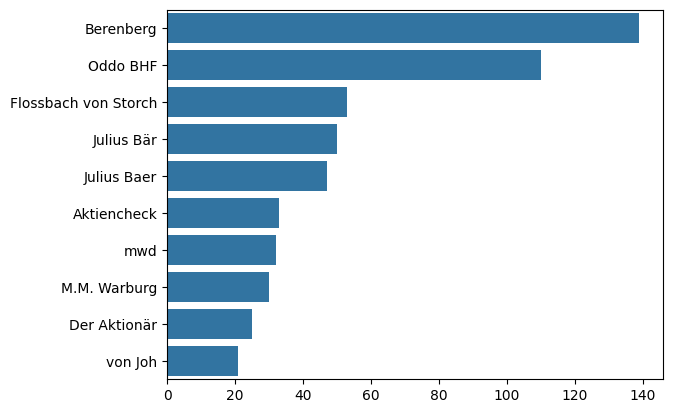

In [21]:
# Apply the NER function 
per_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, ent="PERSON"))
per_en = [i for x in per_en for i in x]

# Count the occurrences of each entity
counter = Counter(per_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### GPE / Geo-Political Entity (Countries, cities, states)

<Axes: >

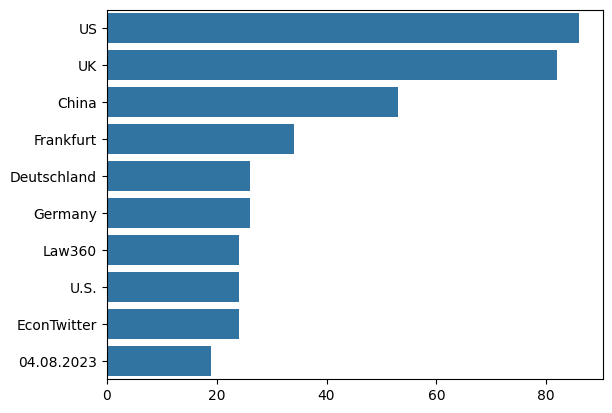

In [22]:
# Apply the NER function 
gpe_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "GPE"))
gpe_en = [i for x in gpe_en for i in x]

# Count the occurrences of each entity
counter = Counter(gpe_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### CARDINAL (Numerals that do not fall under another type)

<Axes: >

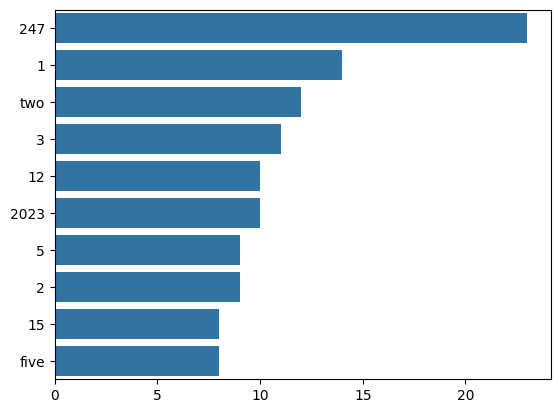

In [23]:
# Apply the NER function 
car_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "CARDINAL"))
car_en = [i for x in car_en for i in x]

# Count the occurrences of each entity
counter = Counter(car_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### EVENT (Named hurricanes, battles, wars, sports events, etc.)

<Axes: >

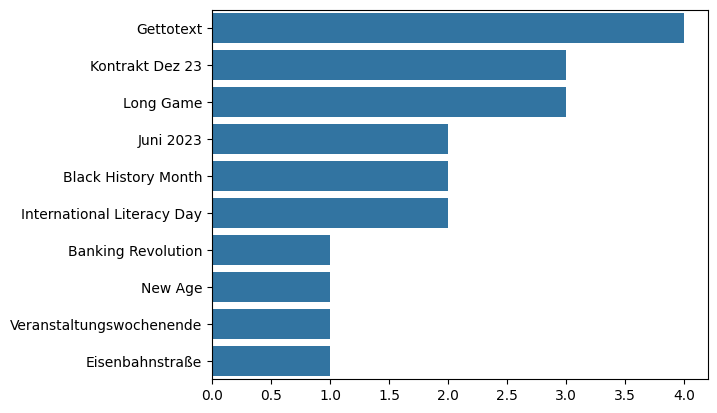

In [24]:
# Apply the NER function 
eve_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "EVENT"))
eve_en = [i for x in eve_en for i in x]

# Count the occurrences of each entity
counter = Counter(eve_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### MONEY (Monetary values, including unit)

<Axes: >

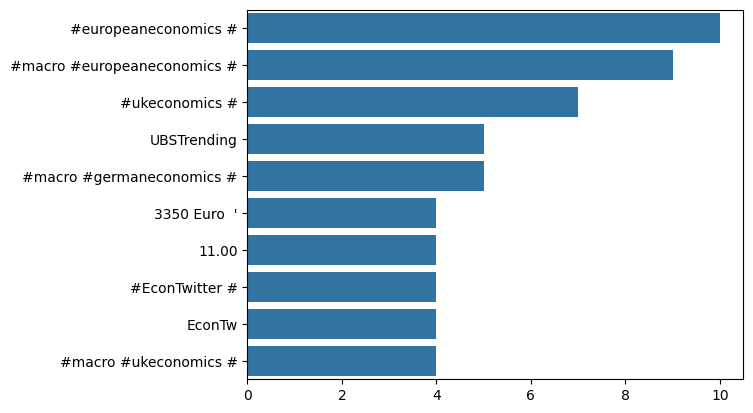

In [25]:
# Apply the NER function 
mon_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "MONEY"))
mon_en = [i for x in mon_en for i in x]

# Count the occurrences of each entity
counter = Counter(mon_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## NER Analysis - German News Title

### Analysis Setup

In [26]:
%%capture
!python -m spacy download de_core_news_lg

In [27]:
# Load the German language model
nlp_de = spacy.load('de_core_news_lg')

# Access the pipeline components to get the labels
ner_labels = nlp_de.get_pipe("ner").labels

# Print the labels and their descriptions
for label in ner_labels:
    print(f"Type: {label}, Description: {spacy.explain(label)}")

Type: LOC, Description: Non-GPE locations, mountain ranges, bodies of water
Type: MISC, Description: Miscellaneous entities, e.g. events, nationalities, products or works of art
Type: ORG, Description: Companies, agencies, institutions, etc.
Type: PER, Description: Named person or family.


### Entity Categories

<Axes: >

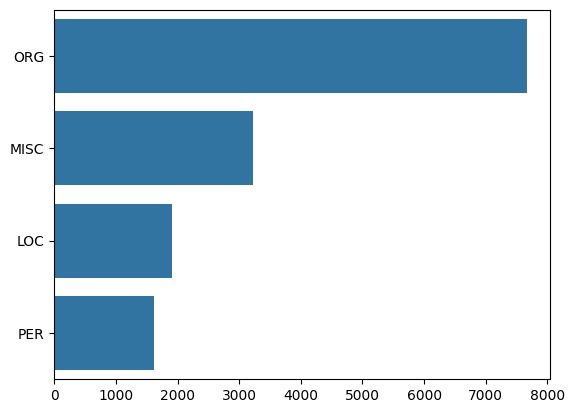

In [28]:
# Define the NER function
def ner_de_tit(text, ent=None):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function
ent_de = df_de['news_title'].apply(lambda x: ner_de_tit(x))
ent_de = [i for x in ent_de for i in x]

# Count the occurrences of each entity
counter = Counter(ent_de)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### ORG / Organization (Companies, agencies, institutions, etc.)

<Axes: >

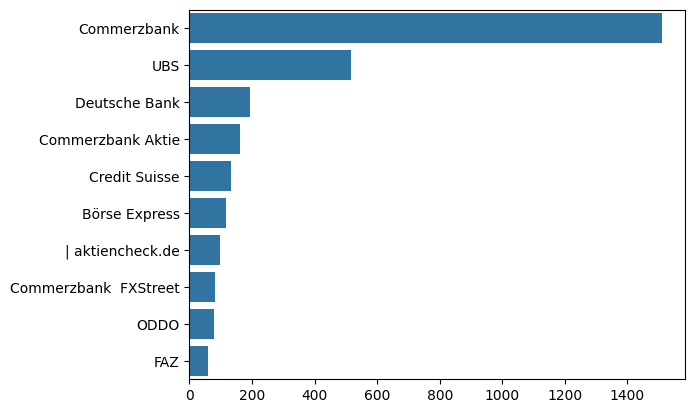

In [29]:
def ner_de_tit(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function 
org_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, ent="ORG"))
org_de = [i for x in org_de for i in x]

# Count the occurrences of each entity
counter = Counter(org_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### PER / Person (Named person or family)

<Axes: >

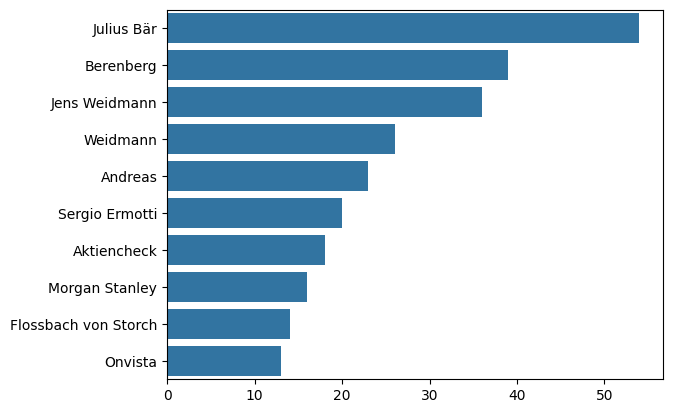

In [30]:
# Apply the NER function
per_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "PER"))
per_de = [i for x in per_de for i in x]

# Count the occurrences of each entity
counter = Counter(per_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### MISC / Miscellaneous entities (e.g. events, nationalities, products or works of art)

<Axes: >

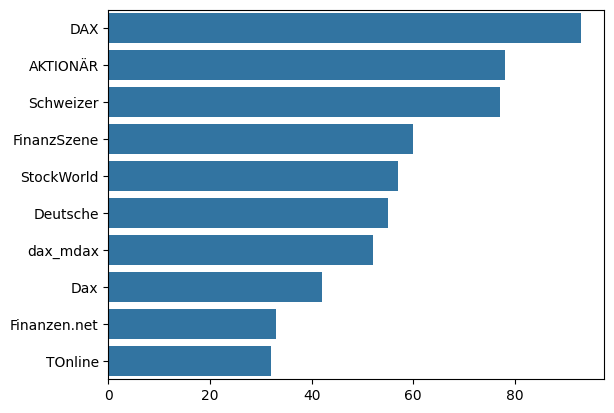

In [31]:
# Apply the NER function 
misc_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "MISC"))
misc_de = [i for x in misc_de for i in x]

# Count the occurrences of each entity
counter = Counter(misc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### LOC / Location (Non-GPE locations, mountain ranges, bodies of water)

<Axes: >

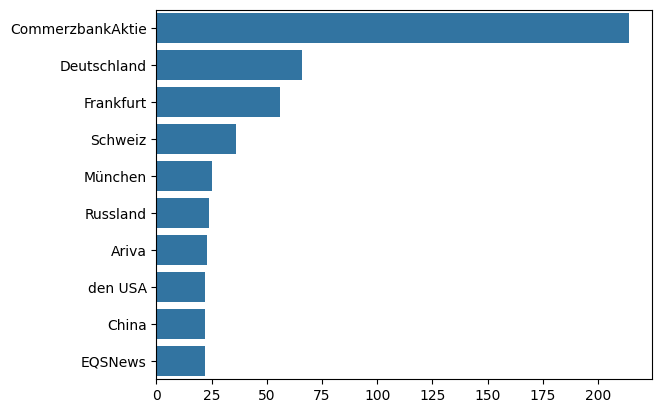

In [32]:
# Apply the NER function 
loc_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "LOC"))
loc_de = [i for x in loc_de for i in x]

# Count the occurrences of each entity
counter = Counter(loc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## Model - English - News Content

### Entity Categories

<Axes: >

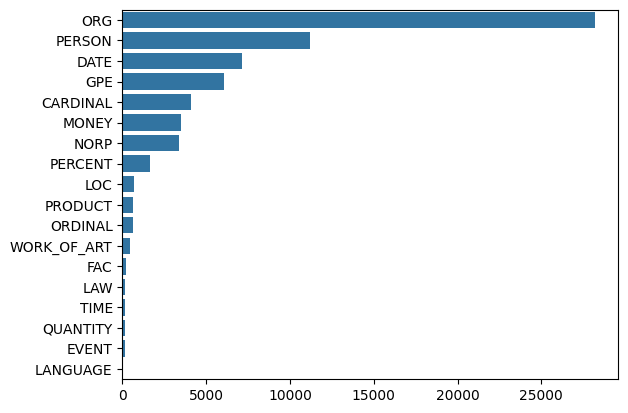

In [33]:
# Define the NER function
def ner_en_cont(text):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function to the 'news_title' column, handling float values
ent_en = df_en['news_content'].apply(lambda x: ner_en_cont(x))
ent_en = [i for x in ent_en for i in x]

# Count the occurrences of each entity
counter = Counter(ent_en)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### ORG / Organization (Companies, agencies, institutions, etc.)

<Axes: >

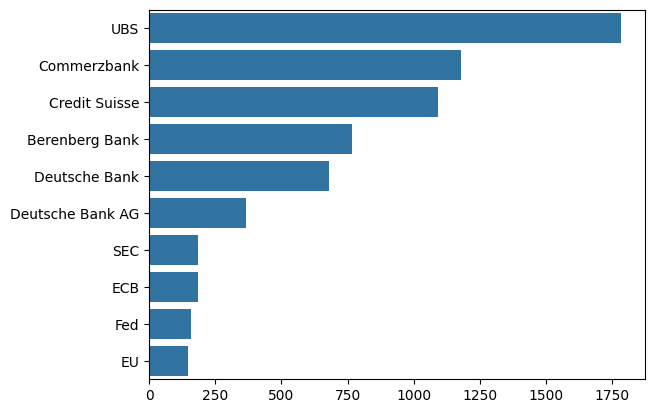

In [34]:
def ner_en_cont(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function 
org_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, ent="ORG"))
org_en = [i for x in org_en for i in x]

# Count the occurrences of each entity
counter = Counter(org_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### PERSON (People, including fictional)

<Axes: >

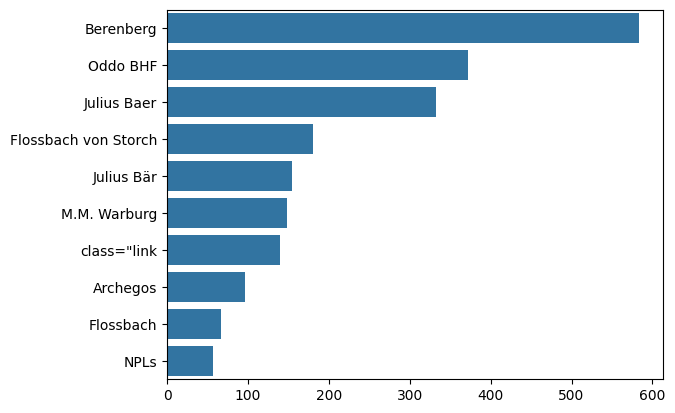

In [35]:
# Apply the NER function
per_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "PERSON"))
per_en = [i for x in per_en for i in x]

# Count the occurrences of each entity
counter = Counter(per_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### GPE / Geo-Political Entity (Countries, cities, states)

<Axes: >

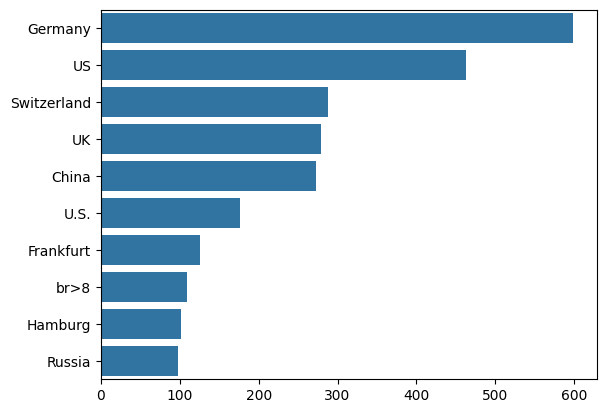

In [36]:
# Apply the NER function
gpe_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "GPE"))
gpe_en = [i for x in gpe_en for i in x]

# Count the occurrences of each entity
counter = Counter(gpe_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### CARDINAL (Numerals that do not fall under another type)

<Axes: >

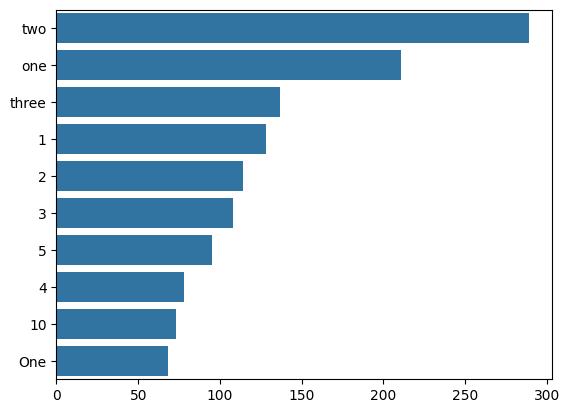

In [37]:
# Apply the NER function
car_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "CARDINAL"))
car_en = [i for x in car_en for i in x]

# Count the occurrences of each entity
counter = Counter(car_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### EVENT (Named hurricanes, battles, wars, sports events, etc.)

<Axes: >

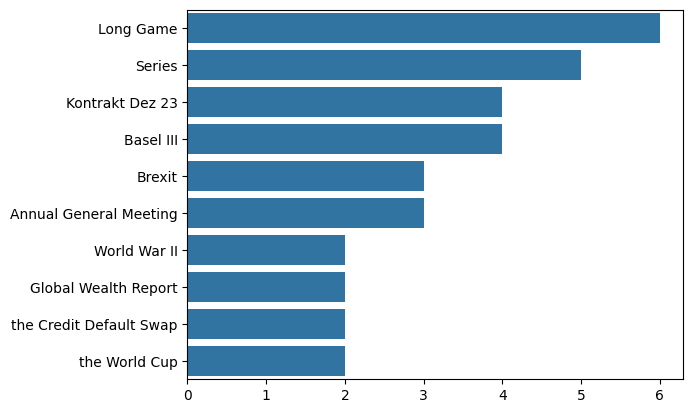

In [38]:
# Apply the NER function
eve_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "EVENT"))
eve_en = [i for x in eve_en for i in x]

# Count the occurrences of each entity
counter = Counter(eve_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### MONEY (Monetary values, including unit)

<Axes: >

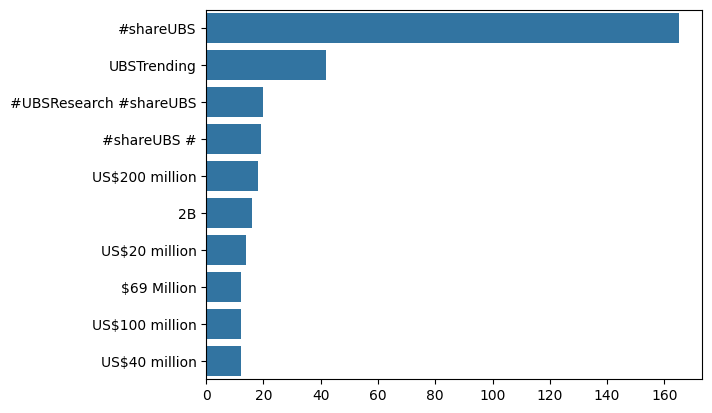

In [39]:
# Apply the NER function 
mon_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "MONEY"))
mon_en = [i for x in mon_en for i in x]

# Count the occurrences of each entity
counter = Counter(mon_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

###  LOC / Location (Non-GPE locations, mountain ranges, bodies of water)

<Axes: >

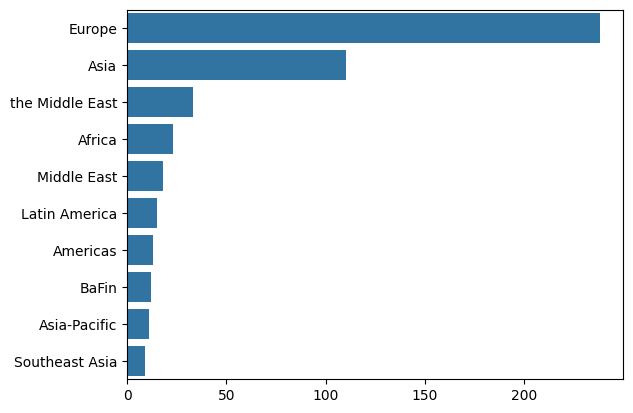

In [45]:
# Apply the NER function 
loc_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "LOC"))
loc_en = [i for x in loc_en for i in x]

# Count the occurrences of each entity
counter = Counter(loc_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## Model - German - News Content

### Entity Categories

<Axes: >

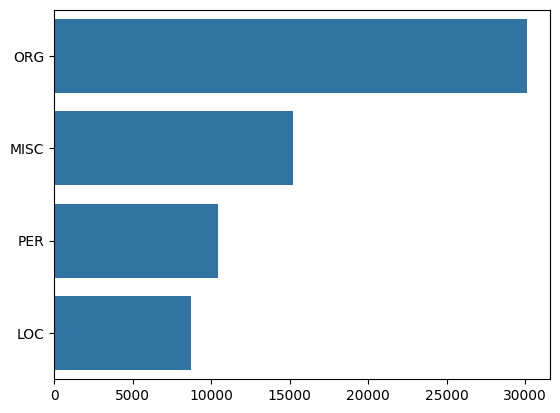

In [40]:
# Define the NER function
def ner_de_cont(text):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function
ent_de = df_de['news_content'].apply(lambda x: ner_de_cont(x))
ent_de = [i for x in ent_de for i in x]

# Count the occurrences of each entity
counter = Counter(ent_de)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### ORG / Organization (Companies, agencies, institutions, etc.)

<Axes: >

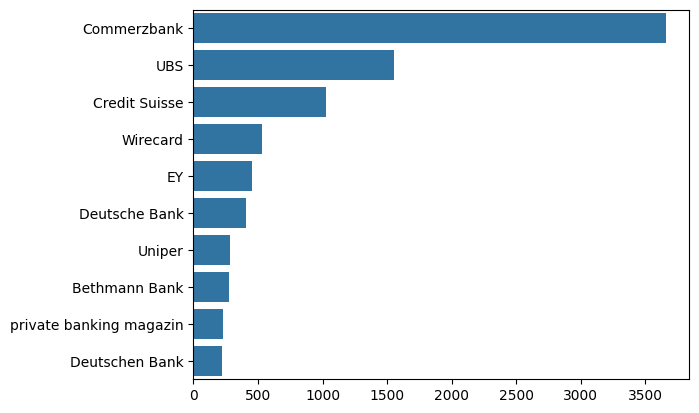

In [41]:
def ner_de_cont(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function
org_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, ent="ORG"))
org_de = [i for x in org_de for i in x]

# Count the occurrences of each entity
counter = Counter(org_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### PER / Person (Named person or family)

<Axes: >

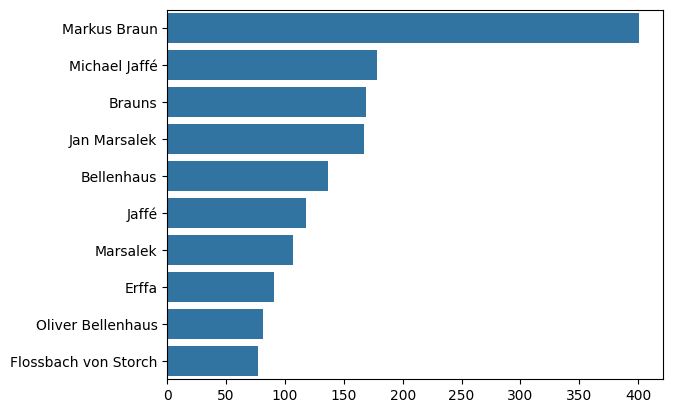

In [42]:
# Apply the NER function
per_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "PER"))
per_de = [i for x in per_de for i in x]

# Count the occurrences of each entity
counter = Counter(per_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### MISC / Miscellaneous entities (e.g. events, nationalities, products or works of art)

<Axes: >

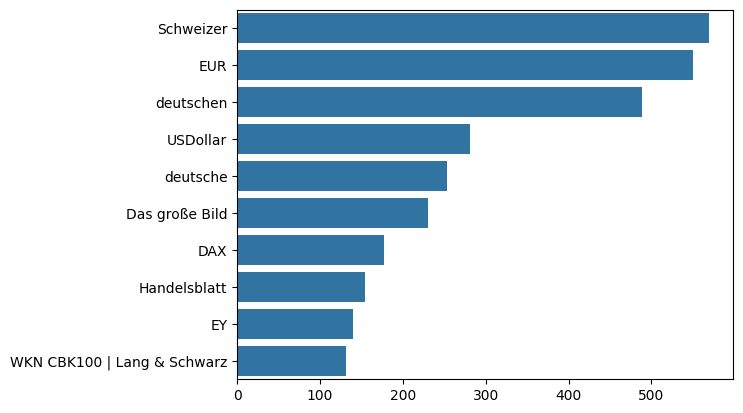

In [43]:
# Apply the NER function 
misc_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "MISC"))
misc_de = [i for x in misc_de for i in x]

# Count the occurrences of each entity
counter = Counter(misc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

### LOC / Location (Non-GPE locations, mountain ranges, bodies of water)

<Axes: >

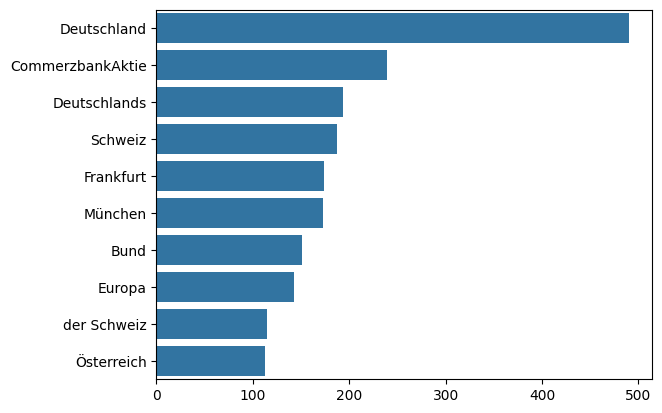

In [44]:
# Apply the NER function 
loc_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "LOC"))
loc_de = [i for x in loc_de for i in x]

# Count the occurrences of each entity
counter = Counter(loc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)